## Analyising overlap in Higher-Order contact Networks


To illustrate how different parameters affect the resulting higher-order structure, we apply the **maximal-clique-with-overlap method** to real-world proximity data from the **Copenhagen Network Study**. This dataset provides **high-resolution Bluetooth proximity data** among university students. -> ref: https://www.nature.com/articles/s41597-019-0325-x

We construct hypergraphs by varying both the time window $∆t = {5, 10, 15, 30}$ minutes and the minimum contact threshold
$C = {1, 3, 5, 10}$, and compute the corresponding overlap matrix A in each case. 

In [6]:
from overlap_func import * 
import numpy as np
import networkx as nx
import pandas as pd
import random
import collections
import matplotlib.pyplot as plt
import os
import json
from time import time
import xgi as xgi
from contact_data_process_func import *

In [8]:
dataset_dir = 'processed_contact_data/'
time_windows = [5,10,15,30]
thrs = [1,3,5,10]
files=[]
H_originals=[]
dataset = 't_edges_dbm74'

c=0
for i in time_windows:
    for j in thrs:
        files.append(r'Time window '+ str(i) + 'min contacts ' + str(j))
        filename = dataset_dir+'25daysaggr_'+str(i)+'min_cliques_thr'+str(j)+'_'+dataset+'.json'
        cliques_list = json.load(open(filename,'r'))
        #print(cliques_list)
        print(files[c])
        H = xgi.Hypergraph(cliques_list)
        H_originals.append(H)
        c+=1

Time window 5min contacts 1
Time window 5min contacts 3
Time window 5min contacts 5
Time window 5min contacts 10
Time window 10min contacts 1
Time window 10min contacts 3
Time window 10min contacts 5
Time window 10min contacts 10
Time window 15min contacts 1
Time window 15min contacts 3
Time window 15min contacts 5
Time window 15min contacts 10
Time window 30min contacts 1
Time window 30min contacts 3
Time window 30min contacts 5
Time window 30min contacts 10


## Basic cleaning and analysis of hyperdege dsitribution

We start by looking at the distribution of hyperdges in different orders of interaction 

In [13]:
# ------------------------------------------------------------
# Clean and Filter Hypergraphs
# ------------------------------------------------------------
# This block processes all hypergraphs loaded in H_originals.
# For each, it:
#   - Reports the number of isolated nodes and duplicate edges
#   - Cleans the hypergraph (removing multiedges, singletons, etc.)
#   - Checks connectivity
#   - Stores the cleaned version in H_s
# ------------------------------------------------------------

H_s = []  # List to store cleaned hypergraphs

# Loop over all originally loaded hypergraphs
for i in range(len(H_originals)):
    print('------------------------------------------------------------')
    print(files[i])  # Print dataset label for reference

    # Retrieve the original hypergraph
    H_original = H_originals[i]

    # Identify and count isolated nodes (nodes not in any hyperedge)
    isolated_nodes = H_original.nodes.isolates()
    print("Number of isolated nodes:", len(isolated_nodes))

    # Identify and count duplicate hyperedges (identical edge sets)
    duplicated_edges = H_original.edges.duplicates()
    print("Number of duplicated edges:", len(duplicated_edges))

    # --------------------------------------------------------
    # Clean up the hypergraph
    #   multiedges=False  → remove duplicate hyperedges
    #   singletons=False  → remove single-node hyperedges
    #   isolates=False    → remove isolated nodes
    #   relabel=True      → reindex nodes sequentially
    #   in_place=False    → return a cleaned copy (don’t modify original)
    # --------------------------------------------------------
    H = H_original.cleanup(
        multiedges=False,
        singletons=False,
        isolates=False,
        relabel=True,
        in_place=False
    )

    # Print summary statistics
    print('')
    print("Cleaned hypergraph nodes:", H.num_nodes)
    print("Original number of nodes:", H_original.num_nodes)
    print("Original number of edges:", H_original.num_edges)

    # Check if the cleaned hypergraph is connected
    xgi.is_connected(H)

    # Append cleaned hypergraph to list
    H_s.append(H)


------------------------------------------------------------
Time window 5min contacts 1
Number of isolated nodes: 0
Number of duplicated edges: 0

Cleaned hypergraph nodes: 672
Original number of nodes: 672
Original number of edges: 32985
------------------------------------------------------------
Time window 5min contacts 3
Number of isolated nodes: 0
Number of duplicated edges: 0

Cleaned hypergraph nodes: 664
Original number of nodes: 664
Original number of edges: 12156
------------------------------------------------------------
Time window 5min contacts 5
Number of isolated nodes: 0
Number of duplicated edges: 0

Cleaned hypergraph nodes: 660
Original number of nodes: 660
Original number of edges: 8005
------------------------------------------------------------
Time window 5min contacts 10
Number of isolated nodes: 0
Number of duplicated edges: 0

Cleaned hypergraph nodes: 649
Original number of nodes: 651
Original number of edges: 4377
-----------------------------------------

In [44]:
# ------------------------------------------------------------
# Save Cleaned Hypergraph Edge Lists
# ------------------------------------------------------------
# This block:
#   1. Creates filenames corresponding to each combination
#      of time window and contact threshold.
#   2. Iterates over all cleaned hypergraphs (H_s)
#   3. Extracts their edge lists
#   4. Saves each list as a text file in a specified directory
# ------------------------------------------------------------

file_save = []  # List to store filenames (used when saving edge lists)

# Generate file identifiers based on parameter combinations
for i in time_windows:
    for j in thrs:
        file_save.append('T_window_' + str(i) + '_min_cont_' + str(j))

# ------------------------------------------------------------
# Iterate through all cleaned hypergraphs and save their edges
# ------------------------------------------------------------
for i in range(len(H_s)):
    H = H_s[i]  # Select current hypergraph

    # Retrieve basic info
    T_sizes = H.edges.size.aslist()   # List of hyperedge sizes
    N = H.num_nodes                   # Number of nodes
    edges_list = H.edges.members(dtype=list)  # Get list of node members per hyperedge

    # Print number of hyperedges for reference
    print(len(edges_list))

    # Save edge list as a .txt file (each line = one hyperedge)
    np.savetxt(
        'edges_lists_clean_contact_data/' + 'edge_list_' + file_save[i] + '.txt',
        edges_list,
        fmt='%s'  # Save node IDs as strings
    )


32985
12156
8005
4376
33961
10250
6133
2917
33883
8698
4826
2131
32403
5614
2734
1062


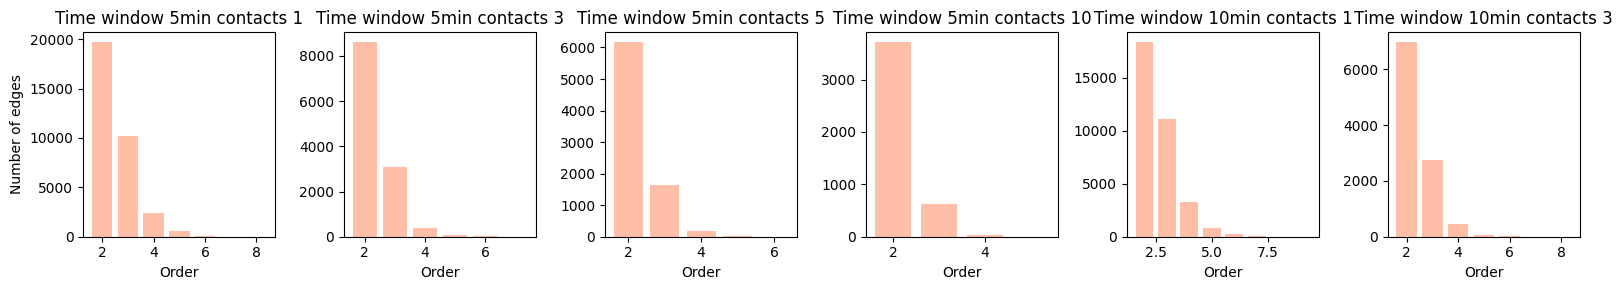

In [29]:
# ------------------------------------------------------------
# Compute and visualize the distribution of hyperedge sizes
# ------------------------------------------------------------
# This section:
#   1. Calculates, for each hypergraph H in H_s, how many
#      hyperedges exist for each order (size).
#   2. Stores those distributions in Edge_size_count.
#   3. Plots histograms (bar charts) showing the distribution
#      of hyperedge sizes for all hypergraphs.
# ------------------------------------------------------------

Edge_size_count = []  # Will store one dictionary per hypergraph

# ------------------------------------------------------------
# Step 1: Count hyperedges of each size for all hypergraphs
# ------------------------------------------------------------
for i in range(len(H_s)):
    H = H_s[i]
    list_of_edges_sizes = H.edges.size.aslist()  # List of all hyperedge sizes
    
    dic_size = {}  # Dictionary: {size: count}
    for ele in list_of_edges_sizes:
        if ele not in dic_size.keys():
            dic_size[ele] = 1
        else:
            dic_size[ele] += 1
            
    Edge_size_count.append(dic_size)

# ------------------------------------------------------------
# Step 2: Plot hyperedge size distributions
# ------------------------------------------------------------
plt.subplots(1, 6, figsize=(16, 3))  # One subplot per hypergraph

for i in range(6):
    plt.subplot(1, 6, i + 1)
    
    H = H_s[i]
    list_of_edges_sizes = H.edges.size.aslist()
    dic_sizs = Edge_size_count[i]
    plt.title(files[i], fontsize=12)
    # Bar plot of hyperedge size frequencies
    plt.bar(dic_sizs.keys(), dic_sizs.values(), color='coral', alpha=0.5)
    
    # Axis labels and basic formatting
    plt.xlabel('Order')
    if i==0:
        plt.ylabel('Number of edges')

plt.tight_layout()


In [33]:
# ------------------------------------------------------------
# Compute inter-order overlap matrices for all hypergraphs
# ------------------------------------------------------------
# This section:
#   1. Iterates over each cleaned hypergraph H in H_s.
#   2. Determines the maximum hyperedge order M_max (capped at 15).
#   3. Computes the inter-order overlap matrix α (alphas) using the
#      function inter_order_overlap_alpha_matrix().
#   4. Stores all α matrices in the list alphas_per_H for later analysis.
# ------------------------------------------------------------

alphas_per_H = []  # List to store α matrices for all hypergraphs

for i in range(len(H_s)):
    print('------------------------------------------------------------------')
    
    H = H_s[i]
    T_sizes = H.edges.size.aslist()  # Get sizes of all hyperedges in H
    
    # Determine the maximum hyperedge order, capped at 15
    M_max = max(T_sizes)
    if M_max > 15:
        M_max = 15

    # Compute the inter-order overlap matrix for this hypergraph
    alphas = inter_order_overlap_alpha_matrix(H, max_order=M_max)
    
    # Store results
    alphas_per_H.append(alphas)


------------------------------------------------------------------
Max order: 8, Min order: 1
Computing overlaps for order 1/8
Computing overlaps for order 2/8
Computing overlaps for order 3/8
Computing overlaps for order 4/8
Computing overlaps for order 5/8
Computing overlaps for order 6/8
Computing overlaps for order 7/8
------------------------------------------------------------------
Max order: 7, Min order: 1
Computing overlaps for order 1/7
Computing overlaps for order 2/7
Computing overlaps for order 3/7
Computing overlaps for order 4/7
Computing overlaps for order 5/7
Computing overlaps for order 6/7
------------------------------------------------------------------
Max order: 6, Min order: 1
Computing overlaps for order 1/6
Computing overlaps for order 2/6
Computing overlaps for order 3/6
Computing overlaps for order 4/6
Computing overlaps for order 5/6
------------------------------------------------------------------
Max order: 5, Min order: 1
Computing overlaps for order 1

In [34]:
# ------------------------------------------------------------
# Compute weighted average inter-order overlap ⟨α⟩ for each hypergraph
# ------------------------------------------------------------
# This section:
#   1. Iterates through all inter-order overlap matrices (alphas_per_H).
#   2. For each hypergraph, computes the weighted average ⟨α⟩.
#   3. The weight for each αₘₙ term is given by the number of m-order edges (|Eₘ|),
#      stored in dic_size.
#   4. NaN values are ignored during computation.
#   5. Results are stored in the list aver_alphas.
# ------------------------------------------------------------

aver_alphas = []  # Stores average α values for each hypergraph

# Helper function to check for NaN values
def isNaN(num):
    return num != num  # NaN is not equal to itself

# Loop over all hypergraphs
for i in range(len(H_s)):
    alphas = alphas_per_H[i]       # Inter-order overlap matrix for current hypergraph
    dic_size = Edge_size_count[i]  # Dictionary: {order -> number of hyperedges}

    # Initialize accumulators
    sum_alpha = 0     # Weighted sum of α values
    alphas_num = 0    # Total number of valid α entries
    wgh = 0           # Total weight (sum of |Eₘ|)

    # Iterate through the α matrix
    for j in range(len(alphas)):
        for k in range(len(alphas[0])):
            if isNaN(alphas[j][k]):  # Skip invalid entries
                continue

            # Weighted sum — each αₘₙ weighted by number of edges of order m
            sum_alpha += alphas[j][k] * dic_size[j + 2]
            alphas_num += 1
            wgh += dic_size[j + 2]

    # Compute weighted average ⟨α⟩ if weights are non-zero
    if wgh != 0:
        aver_alpha = sum_alpha / wgh
        aver_alphas.append(aver_alpha)
        print(aver_alpha)


0.7109940437794412
0.7191468087471049
0.7979032931826859
0.9226645320187318
0.5758092749351997
0.5963629330623135
0.7026845027357037
0.859570304212813
0.5338214659400835
0.5370813666255317
0.7153217729448734
0.7869255730079329
0.4052689176438623
0.5089789418229446
0.5354577663330854
0.6099315256611781


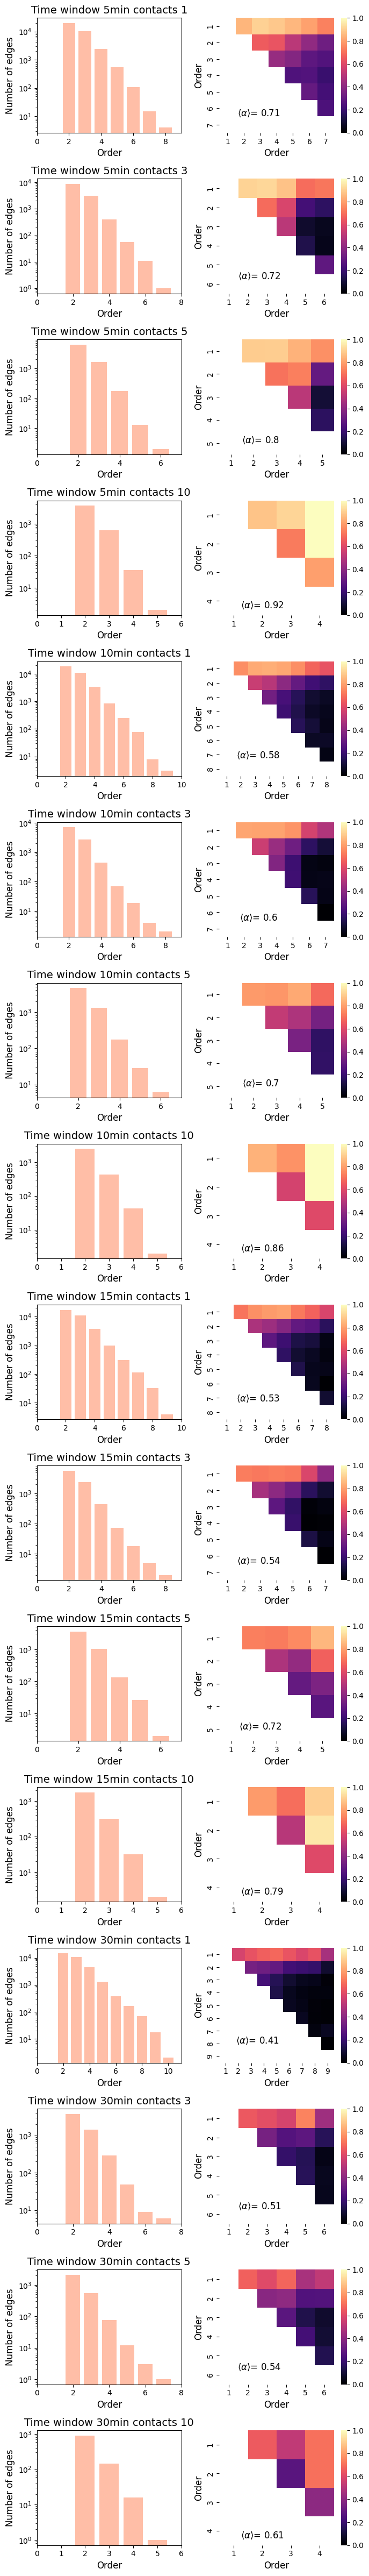

In [36]:
# ------------------------------------------------------------
# Visualization of Hypergraph Properties
# ------------------------------------------------------------
# This section produces two plots for each hypergraph:
#   (1) Left column  — Distribution of hyperedge sizes (log scale).
#   (2) Right column — Inter-order overlap heatmap (α matrix).
#
# The figure dynamically adjusts in height based on the number of hypergraphs (len(H_s)).
# Each row corresponds to a single dataset.
# ------------------------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two columns per dataset (Histogram + Heatmap)
fig, axs = plt.subplots(len(H_s), 2, figsize=(7, 3 * len(H_s)))  # Adjust height dynamically

# Ensure axs is a 2D array, even if there's only one hypergraph
if len(H_s) == 1:
    axs = axs.reshape(1, 2)

# ------------------------------------------------------------
# Iterate through each hypergraph and plot results
# ------------------------------------------------------------
for i in range(len(H_s)):
    H = H_s[i]
    T_sizes = H.edges.size.aslist()           # List of hyperedge orders
    M_max = min(max(T_sizes), 15)             # Cap maximum order at 15 for visualization clarity

    # ========================================================
    # (1) Left Panel: Distribution of Hyperedge Sizes
    # ========================================================
    axs[i, 0].set_title(files[i], fontsize=14)
    dic_sizes = Edge_size_count[i]             # Edge count per order

    # Bar plot showing how many hyperedges exist for each order
    axs[i, 0].bar(dic_sizes.keys(), dic_sizes.values(), color='coral', alpha=0.5)

    # Set axes limits and labels
    axs[i, 0].set_xlim((0, M_max + 1))
    axs[i, 0].set_xlabel('Order', fontsize=12)
    axs[i, 0].set_ylabel('Number of edges', fontsize=12)
    axs[i, 0].set_yscale('log')                # Log scale to handle wide range of edge counts

    # ========================================================
    # (2) Right Panel: Inter-Order Overlap Heatmap
    # ========================================================
    x = range(1, M_max)
    y = range(1, M_max)

    # Plot α matrix (inter-order overlap)
    sns.heatmap(
        alphas_per_H[i],
        xticklabels=x,
        yticklabels=y,
        square=True,
        cmap="magma",
        vmin=0, vmax=1,
        ax=axs[i, 1]
    )

    # Annotate the average ⟨α⟩ value on each heatmap
    axs[i, 1].text(
        M_max * 0.3, M_max * 0.75,
        r'$\langle \alpha \rangle$= ' + str(round(aver_alphas[i], 2)),
        fontsize=12, ha="center"
    )

    # Label axes
    axs[i, 1].set_xlabel('Order', fontsize=12)
    axs[i, 1].set_ylabel('Order', fontsize=12)

# ------------------------------------------------------------
# Final layout adjustments
# ------------------------------------------------------------
plt.tight_layout()
plt.show()


In [37]:
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
def truncate_colormap(cmap, minval=0.2, maxval=1.0, n=256):
    new_cmap = LinearSegmentedColormap.from_list(
        f"trunc({cmap.name},{minval:.2f},{maxval:.2f})",
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap


min_sat=0.1
# Use a truncated version of 'Greens' that starts at a more saturated green
cmap_ = truncate_colormap(cm.get_cmap('PuBu'), minval=min_sat)
cmap_.set_bad('white',0.2)


files1=[]
for i in time_windows:
    for j in thrs:
        files1.append( r'$\Delta t=$'+ str(i) +  r'min, $C_{min}$= ' + str(j))

C:\Users\jg3509phd\AppData\Local\Temp\ipykernel_30164\3597024080.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_ = truncate_colormap(cm.get_cmap('PuBu'), minval=min_sat)


C:\Users\jg3509phd\AppData\Local\Temp\ipykernel_30164\3552722176.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Reserve space for colorbar


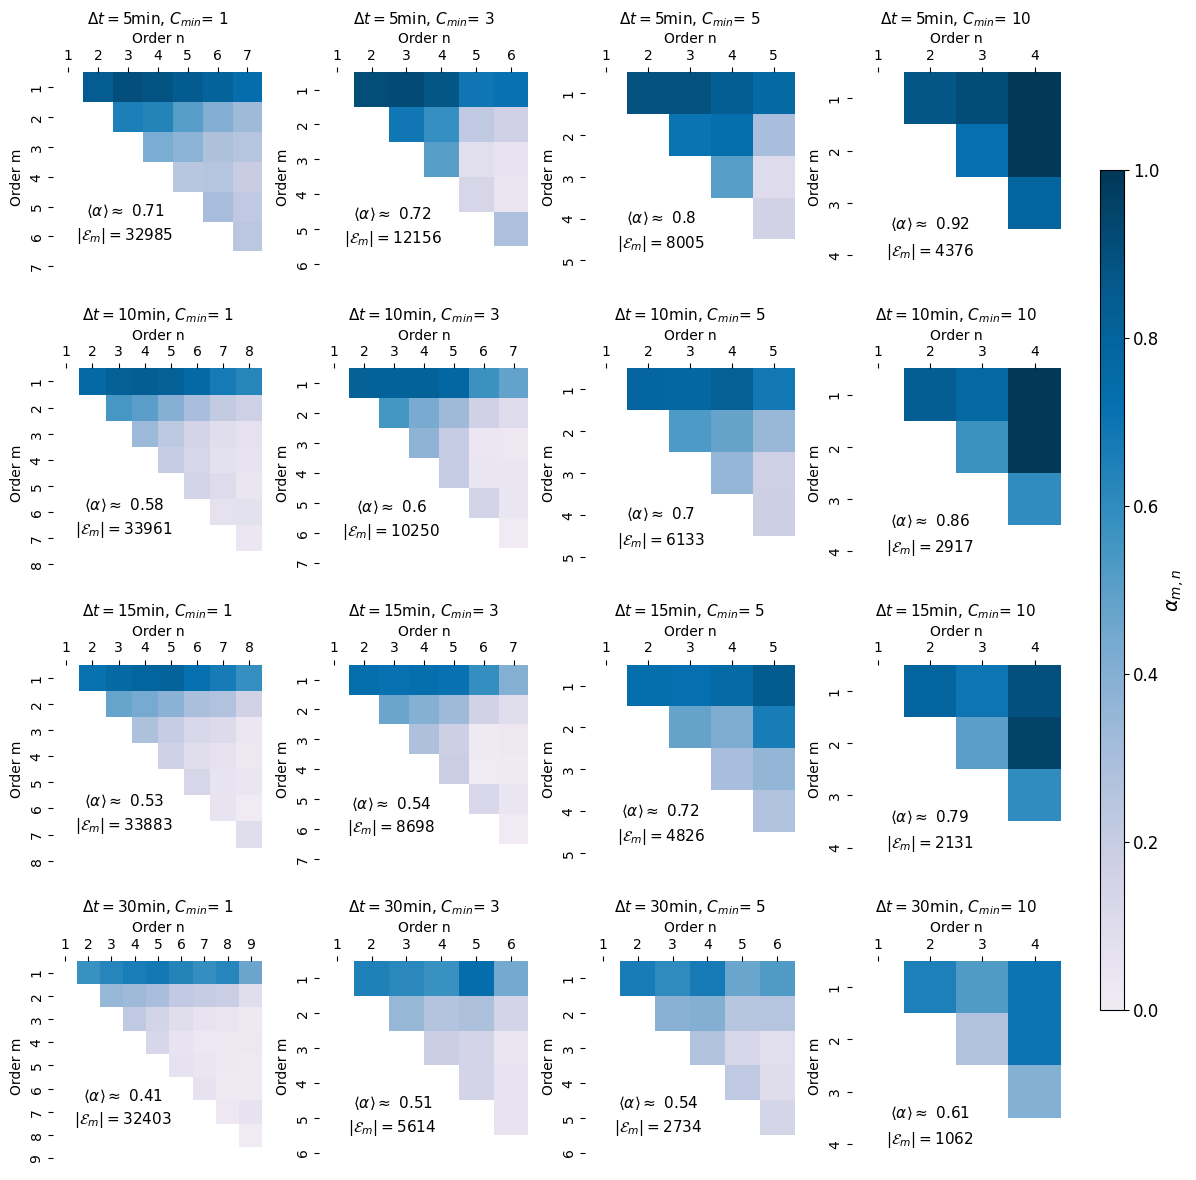

In [38]:
# ------------------------------------------------------------
# Visualization: Inter-Order Overlap Matrices for Contact-Derived Hypergraphs
# ------------------------------------------------------------
# This code generates a 4×4 grid of heatmaps showing the inter-order overlap
# matrix (α_{m,n}) for each hypergraph derived from contact data.
# Each heatmap corresponds to a different combination of time window Δt
# and contact threshold C.
#
# The overlap α_{m,n} quantifies the fraction of m-order hyperedges that
# are fully contained within n-order hyperedges, capturing the degree of
# structural embedding across interaction orders.
# ------------------------------------------------------------


# Create a 4x4 grid for the 16 datasets
fig, axs = plt.subplots(4, 4, figsize=(12, 12))

# Ensure axs is always a 2D array for consistent indexing
axs = axs.reshape(4, 4)

# List to store heatmap objects for colorbar reference
heatmaps = []

c = 0  # Counter over datasets
for i in range(4):
    for j in range(4):
        H = H_s[c]  # Select the c-th hypergraph

        # Determine maximum hyperedge order (capped at 15 for readability)
        T_sizes = H.edges.size.aslist()
        M_max = min(max(T_sizes), 15)

        # Define axes labels
        x = range(1, M_max)
        y = range(1, M_max)

        axs[i, j].set_title(files1[c], fontsize=11)

        # ------------------------------------------------------------
        # Plot the heatmap (inter-order overlap matrix)
        # ------------------------------------------------------------
        hm = sns.heatmap(
            alphas_per_H[c],
            xticklabels=x,
            yticklabels=y,
            square=True,
            cmap=cmap_,  # Custom colormap defined elsewhere
            vmin=0, vmax=1,
            ax=axs[i, j],
            cbar=False  # Disable individual colorbars
        )

        # Store the heatmap handle (for shared colorbar later)
        heatmaps.append(hm)

        # ------------------------------------------------------------
        # Add textual annotations for summary metrics
        # ------------------------------------------------------------
        axs[i, j].text(
            M_max * 0.3, M_max * 0.6,
            r'$\langle \alpha \rangle \approx$ ' + str(round(aver_alphas[c], 2)),
            fontsize=11, ha="center"
        )
        axs[i, j].text(
            M_max * 0.3, M_max * 0.7,
            r'$|\mathcal{E}_m| = $' + str(len(H.edges.size.aslist())),
            fontsize=11, ha="center"
        )

        # ------------------------------------------------------------
        # Format axes
        # ------------------------------------------------------------
        axs[i, j].set_xlabel('Order n', fontsize=10)
        axs[i, j].set_ylabel('Order m', fontsize=10)
        axs[i, j].xaxis.set_ticks_position('top')
        axs[i, j].xaxis.set_label_position('top')

        c += 1

# ------------------------------------------------------------
# Add a single shared colorbar for all heatmaps
# ------------------------------------------------------------
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(heatmaps[0].collections[0], cax=cbar_ax)
cbar.set_label(r'$\alpha_{m,n}$', fontsize=14)
cbar.ax.tick_params(labelsize=12)

# Adjust layout and save figure
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Reserve space for colorbar
#plt.savefig('HG_contact_nets.pdf', dpi=300)
plt.show()


In [39]:
files2=[r'$\Delta t$=5min', r'$\Delta t$=10min',
       r'$\Delta t$=15min',r'$\Delta t$=30min']

C:\Users\jg3509phd\AppData\Local\Temp\ipykernel_30164\3860466972.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for colorbar on the right


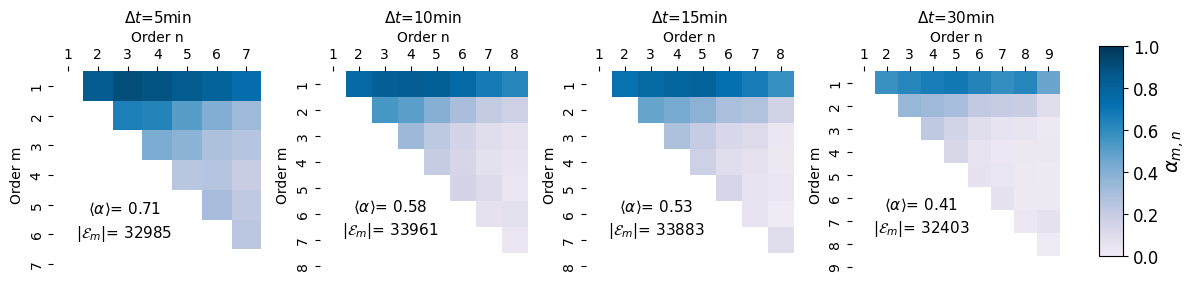

In [40]:

fig, axs = plt.subplots(1, 4, figsize=(12,3))  # 4x4 grid

# Ensure axs is always a 2D array
axs = axs.reshape(1, 4)

c_s=[0,4,8,12]
c=0
heatmaps = []  # To store heatmap mappables for the colorbar

for i in [0]:
    for j in [0,1,2,3]:
        H = H_s[c_s[c]]
        T_sizes = H.edges.size.aslist()
        M_max = min(max(T_sizes), 15)

        x = range(1, M_max)
        y = range(1, M_max)

        axs[i, j].set_title(files2[c], fontsize=11)

        # Draw heatmap without colorbar
        hm = sns.heatmap(
            alphas_per_H[c_s[c]],
            xticklabels=x, yticklabels=y,
            square=True, cmap=cmap_, vmin=0, vmax=1,
            ax=axs[i, j], cbar=False
        )

        heatmaps.append(hm)  # Save the heatmap mappable for later

        axs[i, j].text(
            M_max*0.3, M_max*0.6,
            r'$\langle \alpha \rangle$= ' + str(round(aver_alphas[c_s[c]], 2)),
            fontsize=11, ha="center"
        )
        axs[i, j].text(
            M_max*0.3, M_max*0.7,
            r'$|\mathcal{E}_m|$= ' + str(round(len(H.edges.size.aslist()), 2)),
            fontsize=11, ha="center"
        )
        axs[i, j].set_xlabel('Order n', fontsize=10)
        axs[i, j].set_ylabel('Order m', fontsize=10)
        axs[i, j].xaxis.set_ticks_position('top')
        axs[i, j].xaxis.set_label_position('top')
        #axs[i, j].invert_yaxis()
        c += 1

# Add a single colorbar using the first heatmap's mappable
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(heatmaps[0].collections[0], cax=cbar_ax)
cbar.set_label(r'$\alpha_{m,n}$', fontsize=14)
cbar.ax.tick_params(labelsize=12)
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for colorbar on the right
#plt.savefig('example_contacts_alphas.pdf', dpi=300)
plt.show()


In [41]:
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
def truncate_colormap(cmap, minval=0.2, maxval=1.0, n=256):
    new_cmap = LinearSegmentedColormap.from_list(
        f"trunc({cmap.name},{minval:.2f},{maxval:.2f})",
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap


min_sat=0.1
# Use a truncated version of 'Greens' that starts at a more saturated green
cmap_Greens = truncate_colormap(cm.get_cmap('Greens'), minval=min_sat)
cmap_Greens.set_bad('white',0.2)                           
cmap_Oranges = truncate_colormap(cm.get_cmap('Oranges'), minval=min_sat)
cmap_Oranges.set_bad('white',0.2)
cmap_Blues = truncate_colormap(cm.get_cmap('Blues'), minval=min_sat)
cmap_Blues.set_bad('white',alpha=0.2)
cmap_Reds = truncate_colormap(cm.get_cmap('Reds'), minval=min_sat)
cmap_Reds.set_bad('white',0.2)

C:\Users\jg3509phd\AppData\Local\Temp\ipykernel_30164\1752443666.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_Greens = truncate_colormap(cm.get_cmap('Greens'), minval=min_sat)
C:\Users\jg3509phd\AppData\Local\Temp\ipykernel_30164\1752443666.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_Oranges = truncate_colormap(cm.get_cmap('Oranges'), minval=min_sat)
C:\Users\jg3509phd\AppData\Local\Temp\ipykernel_30164\1752443666.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(o

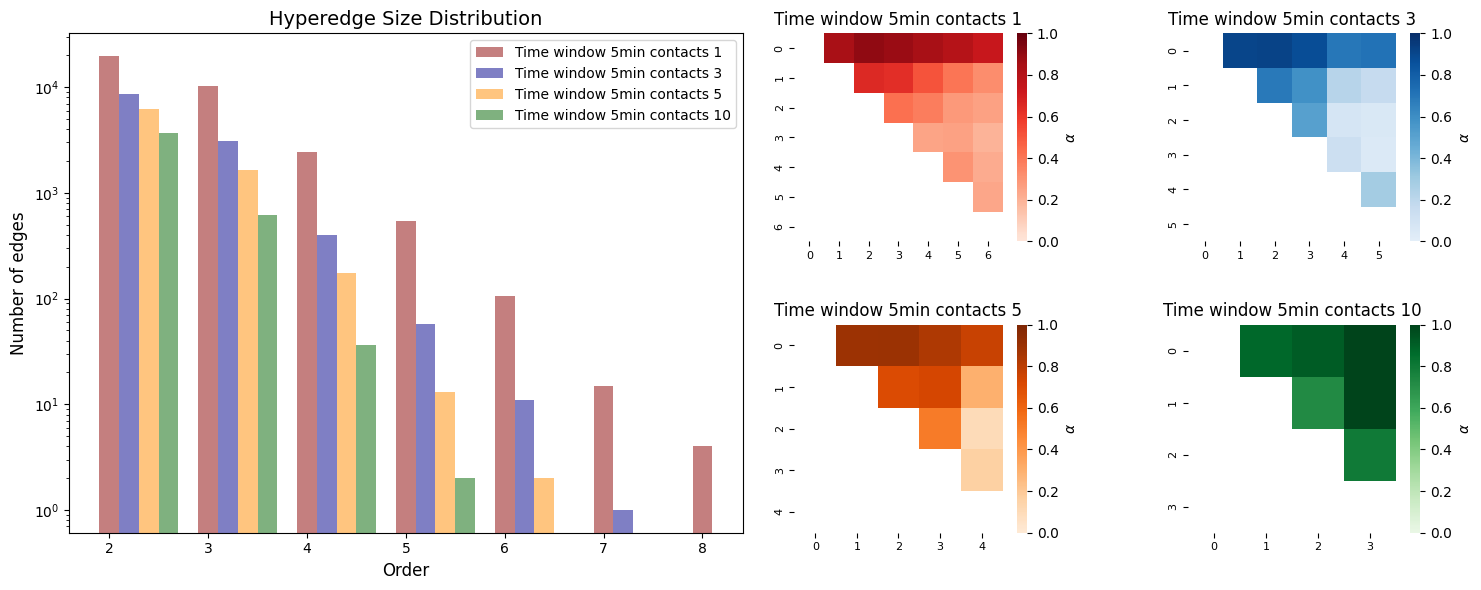

In [42]:
# ------------------------------------------------------------
# Combined Visualization: Bar Plots and Heatmaps for Contact Networks
# ------------------------------------------------------------
# This figure combines:
# 1. A grouped bar plot showing the distribution of hyperedge sizes
#    (number of hyperedges per order) for the first four datasets.
# 2. A 2x2 grid of heatmaps displaying the inter-order overlap matrices
#    (α_{m,n}) for the same datasets.
# ------------------------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define colors and colormaps for consistent visualization
colors = ['darkred', 'darkblue', 'darkorange', 'darkgreen']
cmaps = [cmap_Reds, cmap_Blues, cmap_Oranges, cmap_Greens]
width = 0.2  # Bar width for grouped bar plots

# Create main figure
fig = plt.figure(figsize=(15, 6))

# Define a 1x2 grid: left for bar plots, right for heatmaps
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])

# ------------------------------------------------------------
# Left: Grouped Bar Plot of Hyperedge Size Distributions
# ------------------------------------------------------------
ax_bar = fig.add_subplot(gs[0])

for i in range(4):
    H = H_s[i]
    T_sizes = H.edges.size.aslist()
    dic_sizes = Edge_size_count[i]

    # Maximum hyperedge order (capped at 15)
    M_max = min(max(T_sizes), 15)

    # Adjust x positions for grouped bars
    x_list = [j + i * width for j in list(dic_sizes.keys())]

    # Plot bars
    ax_bar.bar(x_list, dic_sizes.values(), width=width, color=colors[i], alpha=0.5, label=files[i])

ax_bar.set_xlabel('Order', fontsize=12)
ax_bar.set_ylabel('Number of edges', fontsize=12)
ax_bar.set_yscale('log')  # Log scale for broad ranges
ax_bar.legend(fontsize=10)
ax_bar.set_title('Hyperedge Size Distribution', fontsize=14)

# ------------------------------------------------------------
# Right: 2x2 Grid of Heatmaps for Inter-Order Overlap
# ------------------------------------------------------------
# Create a subgridspec for 2x2 heatmaps inside the right panel
gs_bottom = gs[1].subgridspec(2, 2, wspace=0.4, hspace=0.4)

for i in range(4):
    ax = fig.add_subplot(gs_bottom[i // 2, i % 2])
    sns.heatmap(
        alphas_per_H[i],
        ax=ax,
        cmap=cmaps[i],
        square=True,
        vmin=0, vmax=1,
        cbar_kws={'label': r'$\alpha$'}
    )
    ax.set_title(files[i], fontsize=12)
    ax.tick_params(axis='x', labelsize=8, rotation=0)
    ax.tick_params(axis='y', labelsize=8)

# Hide unused axes of the main right panel
axs_heat = fig.add_subplot(gs[1])
axs_heat.axis('off')

# ------------------------------------------------------------
# Final layout adjustments and display
# ------------------------------------------------------------
plt.tight_layout()
plt.show()
